1. Load processed dataset

In [52]:
import os, numpy as np, pandas as pd

LABELED = "../data/processed/reviews_labeled.parquet"
CLEAN   = "../data/processed/reviews_clean.parquet"

DATA = LABELED if os.path.exists(LABELED) else CLEAN
df = pd.read_parquet(DATA)

if "label" not in df.columns and "llm_label" in df.columns:
    df = df.rename(columns={"llm_label": "label"})

print("Loaded:", DATA, "rows:", len(df))
df.head(3)


Loaded: ../data/processed/reviews_clean.parquet rows: 1100


,business_name,author_name,photo_path,has_photo,rating,category_raw,category_id,text_raw,text_stripped,had_html,...,is_empty_text_clean,is_rating_only,looks_promo_heur,looks_rant_no_visit_heur,looks_irrelevant_heur,looks_low_quality_heur,timestamp,review_id,dupe_count,is_exact_dupe
0,Haci'nin Yeri - Yigit Lokantasi,Gulsum Akar,dataset/taste/hacinin_yeri_gulsum_akar.png,True,5,taste,3,We went to Marmaris with my wife for a holiday. We chose this restaurant as a place for dinner based on the reviews and because we wanted juicy food. When we first went there was a serious queue. ...,We went to Marmaris with my wife for a holiday. We chose this restaurant as a place for dinner based on the reviews and because we wanted juicy food. When we first went there was a serious queue. ...,False,...,False,False,False,False,False,False,NaT,197806708066612212,1,False
1,Haci'nin Yeri - Yigit Lokantasi,Oguzhan Cetin,dataset/menu/hacinin_yeri_oguzhan_cetin.png,True,4,menu,1,During my holiday in Marmaris we ate here to fit the food. It's really good that the food is cheap and nice. Eating as much bread as you want is a big plus for those who are not satisfied without ...,During my holiday in Marmaris we ate here to fit the food. It's really good that the food is cheap and nice. Eating as much bread as you want is a big plus for those who are not satisfied without ...,False,...,False,False,False,False,False,False,NaT,-5007835207484769476,1,False
2,Haci'nin Yeri - Yigit Lokantasi,Yasin Kuyu,dataset/outdoor_atmosphere/hacinin_yeri_yasin_kuyu.png,True,3,outdoor_atmosphere,2,Prices are very affordable. The menu in the photo cost 108 liras. You have to wait 10-15 minutes for food. Staff is annoying. Well it tastes good. Boiled meat was delicious.,Prices are very affordable. The menu in the photo cost 108 liras. You have to wait 10-15 minutes for food. Staff is annoying. Well it tastes good. Boiled meat was delicious.,False,...,False,False,False,False,False,False,NaT,-6239589702024109076,1,False


2. Decide target + feature sets

In [53]:
TEXT_COL = "text_clean"

if "label" in df.columns:
    TARGET = "label"
else:
    TARGET = "looks_promo_heur"   # fallback binary

IDENT_OR_TEXT = {
    "business_name","author_name","photo_path","text_raw","text_stripped","text_clean",
    "category_raw","timestamp","review_id"
}

bool_cols_all    = set(df.select_dtypes(include=["boolean"]).columns.tolist())
numeric_cols_all = set(df.select_dtypes(include=["number"]).columns.tolist())

ALL_FEATS = list((bool_cols_all | numeric_cols_all) - IDENT_OR_TEXT - {TARGET})
print("Target:", TARGET)
print("#features:", len(ALL_FEATS))


Target: looks_promo_heur
#features: 30


3. Train/test split

In [54]:
from sklearn.model_selection import train_test_split

X_text = df[TEXT_COL].fillna("")
X_num  = df[ALL_FEATS].fillna(0).astype(float)
y      = df[TARGET]

X_text_tr, X_text_te, X_num_tr, X_num_te, y_tr, y_te = train_test_split(
    X_text, X_num, y,
    test_size=0.2, random_state=42,
    stratify=y if y.nunique()>1 else None
)


4. Vectorise text 

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    min_df=8, max_df=0.5, ngram_range=(1,1), max_features=2000,
    sublinear_tf=True, stop_words="english"
)

X_text_tr_vec = tfidf.fit_transform(X_text_tr)
X_text_te_vec = tfidf.transform(X_text_te)

feat_words = tfidf.get_feature_names_out().tolist()


5. Combine numeric + text 

In [56]:
from scipy.sparse import hstack, csr_matrix

X_hybrid_tr = hstack([csr_matrix(X_num_tr.values), X_text_tr_vec]).tocsr()
X_hybrid_te = hstack([csr_matrix(X_num_te.values), X_text_te_vec]).tocsr()

feat_names_hybrid = list(ALL_FEATS) + feat_words
print("Hybrid shape:", X_hybrid_tr.shape, "features:", len(feat_names_hybrid))


Hybrid shape: (880, 229) features: 229


6. Balance the training set

In [57]:
# Fallback upsampler (no imblearn)
def upsample_to_max(X_sparse, y):
    y = pd.Series(y)
    vc = y.value_counts()
    max_n = vc.max()
    keep_idx = []
    for cls, n in vc.items():
        cls_idx = np.where(y.values == cls)[0]
        if n < max_n:
            add = np.random.choice(cls_idx, size=max_n - n, replace=True)
            cls_idx = np.concatenate([cls_idx, add])
        keep_idx.append(cls_idx)
    keep_idx = np.concatenate(keep_idx)
    return X_sparse[keep_idx], y.iloc[keep_idx].values

X_bal_tr, y_bal_tr = upsample_to_max(X_hybrid_tr, y_tr)
print("Balanced counts:\n", pd.Series(y_bal_tr).value_counts())


Balanced counts:
 False    878
True     878
Name: count, dtype: Int64


7. Train logistic regression

In [58]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(
    penalty="elasticnet", solver="saga",
    l1_ratio=0.5, C=1.0, max_iter=3000, n_jobs=-1
)

clf.fit(X_bal_tr, y_bal_tr)


/opt/anaconda3/envs/techjam311/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,penalty,'elasticnet'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'saga'
,max_iter,3000
,multi_class,'deprecated'


8. Evaluate

              precision    recall  f1-score   support

         0.0      1.000     0.982     0.991       220
         1.0      0.000     0.000     0.000         0

    accuracy                          0.982       220
   macro avg      0.500     0.491     0.495       220
weighted avg      1.000     0.982     0.991       220



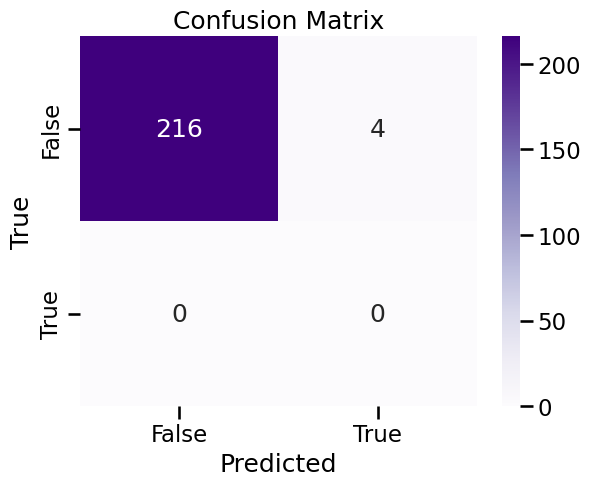

In [59]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns, matplotlib.pyplot as plt

yp = clf.predict(X_hybrid_te)
print(classification_report(y_te, yp, digits=3, zero_division=0))

cm = confusion_matrix(y_te, yp, labels=sorted(set(y)))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
            xticklabels=sorted(set(y)), yticklabels=sorted(set(y)))
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


9. Feature importance analysis

In [60]:
# Global importance
if clf.coef_.shape[0] == 1:
    coef_global = np.abs(clf.coef_[0])
else:
    coef_global = np.mean(np.abs(clf.coef_), axis=0)

importance = pd.Series(coef_global, index=feat_names_hybrid).sort_values(ascending=False)

print("Top 30 features:")
display(importance.head(30))

# Split into numeric vs text
imp_num  = importance[[f for f in importance.index if f in ALL_FEATS]]
imp_text = importance[[f for f in importance.index if f not in ALL_FEATS]]

print("Top numeric features:")
display(imp_num.head(15))

print("Top text features:")
display(imp_text.head(20))


Top 30 features:


contains_coupon           2.295807
know                      0.837380
don                       0.635514
avg_token_len             0.608338
clean                     0.584407
beautiful                 0.534844
pizza                     0.436664
num_pos_words             0.421150
customer                  0.361855
dough                     0.333261
small                     0.280569
rating                    0.259551
looks_low_quality_heur    0.238410
is_short                  0.238410
length_tokens             0.234729
nice                      0.229366
num_neg_words             0.168104
category_id               0.156742
num_caps_tokens           0.155141
num_exclaim               0.139612
unique_token_ratio        0.126622
taste                     0.110777
has_photo                 0.101188
dupe_count                0.101188
food                      0.089457
delicious                 0.085266
service                   0.080417
prices                    0.074712
eat                 

Top numeric features:


contains_coupon           2.295807
avg_token_len             0.608338
num_pos_words             0.421150
rating                    0.259551
looks_low_quality_heur    0.238410
is_short                  0.238410
length_tokens             0.234729
num_neg_words             0.168104
category_id               0.156742
num_caps_tokens           0.155141
num_exclaim               0.139612
unique_token_ratio        0.126622
has_photo                 0.101188
dupe_count                0.101188
length_chars              0.037654
dtype: float64

Top text features:


know         0.837380
don          0.635514
clean        0.584407
beautiful    0.534844
pizza        0.436664
customer     0.361855
dough        0.333261
small        0.280569
nice         0.229366
taste        0.110777
food         0.089457
delicious    0.085266
service      0.080417
prices       0.074712
eat          0.069066
ate          0.062270
like         0.056363
little       0.054892
meat         0.051786
tl           0.050524
dtype: float64

In [62]:
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

sns.set_context("talk")

# 1) Load data
LABELED = "../data/processed/reviews_labeled.parquet"
CLEAN   = "../data/processed/reviews_clean.parquet"
DATA = LABELED if os.path.exists(LABELED) else CLEAN

df = pd.read_parquet(DATA)

# if label came from LLM
if "label" not in df.columns and "llm_label" in df.columns:
    df = df.rename(columns={"llm_label": "label"})

print("Loaded:", DATA, "rows:", len(df))
df.head(3)

# 2) Target + features
if "label" in df.columns:
    TARGET = "label"
else:
    TARGET = "looks_promo_heur"   # fallback binary label

IDENT_OR_TEXT = {
    "business_name","author_name","photo_path","text_raw","text_stripped","text_clean",
    "category_raw","timestamp","review_id"
}

bool_cols_all    = set(df.select_dtypes(include=["boolean"]).columns.tolist())
numeric_cols_all = set(df.select_dtypes(include=["number"]).columns.tolist())

ALL_FEATS = list((bool_cols_all | numeric_cols_all) - IDENT_OR_TEXT - {TARGET})
print("Target:", TARGET)
print("#features:", len(ALL_FEATS))

# 3) Train/test split
X = df[ALL_FEATS].fillna(0).astype(float)
y = df[TARGET]

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.3, random_state=42,
    stratify=y if y.nunique()>1 else None
)

print("\nTrain balance:\n", pd.Series(y_tr).value_counts())
print("\nTest balance:\n",  pd.Series(y_te).value_counts())
classes_sorted = sorted(pd.Series(y_tr).unique())

# 4) Balance training set
def upsample_to_max(X, y):
    """Simple upsampler without imblearn."""
    y = pd.Series(y)
    vc = y.value_counts()
    max_n = vc.max()
    keep_idx = []
    for cls, n in vc.items():
        cls_idx = np.where(y.values == cls)[0]
        if n < max_n:
            add = np.random.choice(cls_idx, size=max_n - n, replace=True)
            cls_idx = np.concatenate([cls_idx, add])
        keep_idx.append(cls_idx)
    keep_idx = np.concatenate(keep_idx)
    return X.iloc[keep_idx], y.iloc[keep_idx].values

X_bal_tr, y_bal_tr = upsample_to_max(X_tr, y_tr)
print("\nBalanced train counts:\n", pd.Series(y_bal_tr).value_counts())

# 5) Train classifier
clf = LogisticRegression(
    penalty="elasticnet", solver="saga",
    l1_ratio=0.5, C=1.0,
    max_iter=3000, n_jobs=-1
)

clf.fit(X_bal_tr, y_bal_tr)

# 6) Evaluate
yp = clf.predict(X_te)
print("\nClassification report:")
print(classification_report(y_te, yp, digits=3, zero_division=0))

cm = confusion_matrix(y_te, yp, labels=classes_sorted)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
            xticklabels=classes_sorted, yticklabels=classes_sorted)
plt.title("Numeric-only Model — Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()

# 7) Feature importance
if clf.coef_.shape[0] == 1:
    coef_global = np.abs(clf.coef_[0])
else:
    coef_global = np.mean(np.abs(clf.coef_), axis=0)

importance = pd.Series(coef_global, index=ALL_FEATS).sort_values(ascending=False)

print("\nTop 20 features:")
display(importance.head(20))

# Save to CSV
os.makedirs("../reports", exist_ok=True)
importance.to_csv("../reports/feature_importance_numeric_only.csv")
print("Saved to ../reports/feature_importance_numeric_only.csv")


Loaded: ../data/processed/reviews_clean.parquet rows: 1100
Target: looks_promo_heur
#features: 30

Train balance:
 looks_promo_heur
False    220
Name: count, dtype: Int64

Test balance:
 looks_promo_heur
False    878
True       2
Name: count, dtype: Int64

Balanced train counts:
 False    220
Name: count, dtype: Int64


ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: np.float64(0.0)